<a href="https://colab.research.google.com/github/InduwaraGayashan001/PyTorch/blob/main/Classification_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# To view Model Summary
!pip install -q torchinfo

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import time

%matplotlib inline

In [ ]:
def set_seeds():
    # set random seed value
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    # Fix seed to make training deterministic.
    if torch.cuda.is_available():
       torch.cuda.manual_seed(SEED_VALUE)
       torch.cuda.manual_seed_all(SEED_VALUE)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

set_seeds()

# Prepare the Dataloader

In [ ]:
# convert to tensors
raw_transform = transforms.Compose([
    transforms.ToTensor()
])

train_set_raw = datasets.FashionMNIST(root="F_MNIST_DATA", download=True, train=True, transform=raw_transform)

# Compute mean and std
all_pixels = torch.cat([img.view(-1) for img,_ in train_set_raw])
mean = all_pixels.mean().item()
std = all_pixels.std().item()


# convert to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Load data
train_set = datasets.FashionMNIST(root="F_MNIST_DATA", download=True, train=True, transform=transform)
val_set = datasets.FashionMNIST(root="F_MNIST_DATA", download=True, train=False, transform=transform)

print(f"Total Train Images:{len(train_set)}")
print(f"Total Validation Images:{len(val_set)}")

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.03MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 58.8MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.6MB/s]


Total Train Images:60000
Total Validation Images:10000


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)

In [ ]:
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

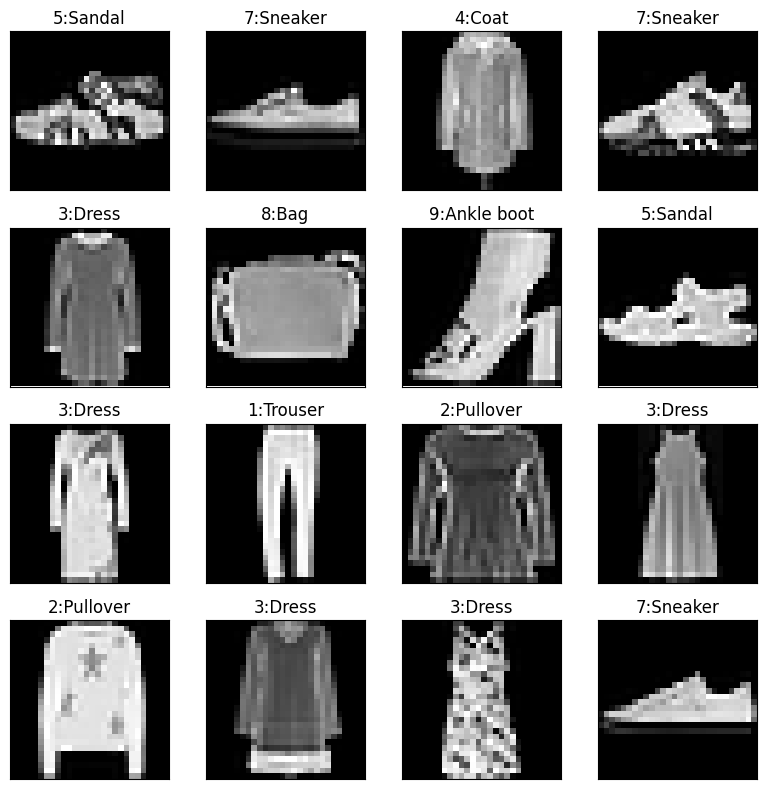

In [ ]:
def visualize_images(trainloader , num_images):
    figure = plt.figure(figsize=(8, 8))
    images, labels = next(iter(trainloader))

    num_rows = 4
    num_cols = int(np.ceil(num_images / num_rows))

    for idx in range(num_images):
        image, label = images[idx], labels[idx]

        ax = figure.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(image), cmap="gray")
        ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

    figure.tight_layout()
    plt.show()

visualize_images(train_loader, 16)

# MLP Model Implementation

In [ ]:
layer = nn.Linear(4, 2)  # Input: 4 features → Output: 2 features
x = torch.tensor([[1.0, 2.0, 3.0, 4.0]])  # Shape: (1, 4)
output = layer(x)  # Shape: (1, 2)
print(output)

tensor([[0.9059, 1.4530]], grad_fn=<AddmmBackward0>)


In [ ]:
bn = nn.BatchNorm1d(3)  # Normalizing 3 features
x = torch.tensor([[1.0, 2.0, 3.0],
                  [4.0, 5.0, 6.0]])
output = bn(x)
print(output)

tensor([[-1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [ ]:
class MLP(nn.Module):

  def __init__(self, num_classes):
    super().__init__()

    self.fc0 = nn.Linear(784,512)
    self.bn0 = nn.BatchNorm1d(512)

    self.fc1 = nn.Linear(512,256)
    self.bn1 = nn.BatchNorm1d(256)

    self.fc2 = nn.Linear(256,128)
    self.bn2 = nn.BatchNorm1d(128)

    self.fc3 = nn.Linear(128,64)
    self.bn3 = nn.BatchNorm1d(64)

    self.fc4 = nn.Linear(64,num_classes)

    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):

    x  = x.view(x.shape[0], -1)

    x = F.relu(self.bn0(self.fc0(x)))
    x = self.dropout(x)

    x = F.relu(self.bn1(self.fc1(x)))

    x = F.relu(self.bn2(self.fc2(x)))
    x = self.dropout(x)

    x = F.relu(self.bn3(self.fc3(x)))

    x = F.log_softmax(self.fc4(x), dim=1)

    return x

mlp_model = MLP(num_classes=10)

In [ ]:
print(summary(mlp_model, input_size=(1, 1, 28, 28), row_settings=["var_names"]))

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

In [ ]:
criterion = F.nll_loss
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)
num_epocs = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training

In [ ]:
def train(model, trainloader, optimizer, criterion, DEVICE):
    model.train()
    model.to(DEVICE)
    running_loss = 0
    correct_predictions = 0
    total_samples =0

    for images, labels in trainloader:

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(trainloader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

In [ ]:
def validation(model, valloader, criterion, DEVICE):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in valloader:

            images, labels = images.to(DEVICE), labels.to(DEVICE)
            output = model(images)

            loss = criterion(output, labels)
            running_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(valloader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

In [ ]:
import time

def main(model, trainloader, valloader, epochs=5, DEVICE ='cuda'):

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []


    for epoch in range(epochs):
        start_time = time.time()

        train_loss, train_accuracy = train(model, trainloader, optimizer, criterion, DEVICE)
        val_loss, val_accuracy = validation(model, valloader, criterion, DEVICE)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}| Time: {epoch_time:.2f} seconds")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Epoch 1/40 | Train Loss: 0.5598, Train Accuracy: 0.8003 | Val Loss: 0.4363, Val Accuracy: 0.8458| Time: 28.56 seconds
Epoch 2/40 | Train Loss: 0.4386, Train Accuracy: 0.8437 | Val Loss: 0.4055, Val Accuracy: 0.8506| Time: 28.06 seconds
Epoch 3/40 | Train Loss: 0.4007, Train Accuracy: 0.8557 | Val Loss: 0.3719, Val Accuracy: 0.8625| Time: 28.97 seconds
Epoch 4/40 | Train Loss: 0.3755, Train Accuracy: 0.8646 | Val Loss: 0.3623, Val Accuracy: 0.8687| Time: 28.06 seconds
Epoch 5/40 | Train Loss: 0.3568, Train Accuracy: 0.8707 | Val Loss: 0.3441, Val Accuracy: 0.8785| Time: 28.50 seconds
Epoch 6/40 | Train Loss: 0.3388, Train Accuracy: 0.8780 | Val Loss: 0.3420, Val Accuracy: 0.8770| Time: 28.35 seconds
Epoch 7/40 | Train Loss: 0.3287, Train Accuracy: 0.8817 | Val Loss: 0.3270, Val Accuracy: 0.8816| Time: 28.16 seconds
Epoch 8/40 | Train Loss: 0.3148, Train Accuracy: 0.8855 | Val Loss: 0.3271, Val Accuracy: 0.8827| Time: 27.90 seconds
Epoch 9/40 | Train Loss: 0.3028, Train Accuracy: 0.8900 

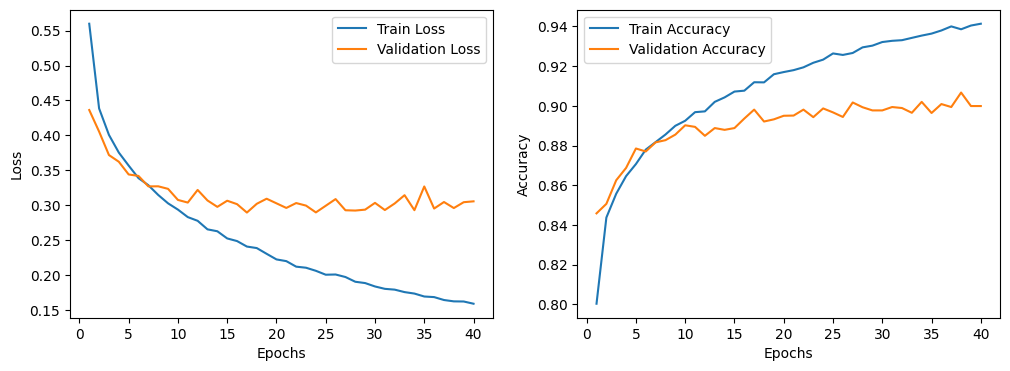

In [ ]:
main(mlp_model, train_loader, val_loader, epochs = num_epocs, DEVICE = DEVICE)

# Inference Results

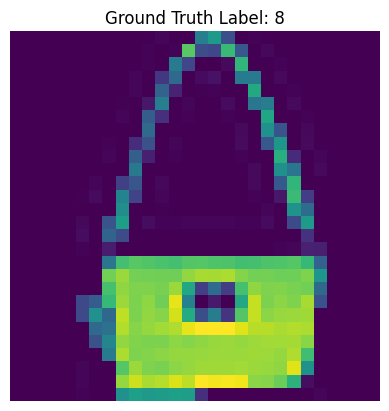

In [20]:
images, gt_labels = next(iter(val_loader))
rand_idx = random.choice(range(len(images)))

plt.imshow(images[rand_idx].squeeze())
plt.title("Ground Truth Label: " + str(int(gt_labels[rand_idx])), fontsize = 12)
plt.axis("off")
plt.show()

In [23]:
# Formatting
bold = f"\033[1m"
reset = f"\033[0m"
mlp_model.eval()

with torch.no_grad():
  batch_outputs = mlp_model(images.to(DEVICE))

prob_score_batch = batch_outputs.softmax(dim=1).cpu()
prob_score_test_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_test_image.argmax()

print("Predictions for each class on the test image:\n")

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
       print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
       print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")



Predictions for each class on the test image:

Class: 0 - T-shirt/top, Probability: 0.006
Class: 1 - Trouser, Probability: 0.001
Class: 2 - Pullover, Probability: 0.001
Class: 3 - Dress, Probability: 0.006
Class: 4 - Coat, Probability: 0.003
Class: 5 - Sandal, Probability: 0.002
Class: 6 - Shirt, Probability: 0.001
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 0.981
Class: 9 - Ankle boot, Probability: 0.000


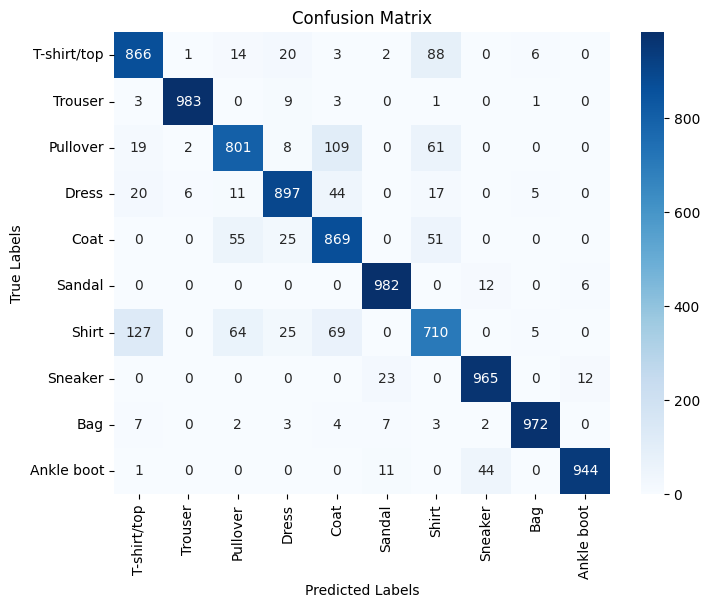

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def predition_batch(model, bath_inputs):
  model.eval()
  batch_outputs = model(bath_inputs)
  with torch.no_grad():
    prob_score_batch = batch_outputs.softmax(dim=1)

  batch_cls_ids = prob_score_batch.argmax(dim =1)

  return batch_cls_ids.cpu()

val_target_labels =[]
val_predicted_labels =[]

for image_batch, target_batch in val_loader:
  image_batch  = image_batch.to(DEVICE)

  batch_pred_cls_id = predition_batch(mlp_model, image_batch)

  val_predicted_labels.append(batch_pred_cls_id)
  val_target_labels.append(target_batch)

val_predicted_labels = torch.cat(val_predicted_labels).numpy()
val_target_label = torch.cat(val_target_labels).numpy()

cm = confusion_matrix(val_target_label, val_predicted_labels)

plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_mapping.values()), yticklabels=list(class_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()